In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

In [116]:

df = pd.read_csv('data/processed_data.csv')
weather_df = pd.read_csv('data/hourly_weather_data.csv')


In [117]:
# Drop the 'Unnamed: 0' column which is the first column
weather_df = weather_df.drop(columns=['Unnamed: 0'])

# Convert the cutoff date to datetime
cutoff_date = pd.to_datetime('2024-03-09 23:00:00')

# Convert the date column to datetime
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Split the data into before and after the cutoff date
weather_df_train = weather_df[weather_df['date'] <= cutoff_date].copy()
weather_df_test = weather_df[weather_df['date'] > cutoff_date].copy()

weather_df = weather_df.set_index('date')
weather_df_train = weather_df_train.set_index('date')
weather_df_test = weather_df_test.set_index('date')

weather_df.index = weather_df.index.strftime('%Y-%m-%d %H')
weather_df_train.index = weather_df_train.index.strftime('%Y-%m-%d %H')
weather_df_test.index = weather_df_test.index.strftime('%Y-%m-%d %H')


In [118]:
# Rename 'id' column to 'date'
df = df.rename(columns={'id': 'date'})
df = df.set_index('date')

# Convert date columns to datetime for proper merging
# df['date'] = pd.to_datetime(df['date'])
# weather_df['date'] = pd.to_datetime(weather_df['date'])

# Merge the dataframes on date
# df = pd.merge(df, weather_df, on='date', how='left')
# df = df.set_index('date')
# df.head()

In [119]:
df.head()

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,...,valeur_PM10_rolling_mean24,valeur_PM10_rolling_std24,valeur_PM10_rolling_mean168,valeur_PM10_rolling_std168,valeur_PM25_rolling_mean24,valeur_PM25_rolling_std24,valeur_PM25_rolling_mean168,valeur_PM25_rolling_std168,NO2_CO_interaction,PM10_PM25_interaction
date,,,,,,,,,,,,,,,,,,,,,
2020-01-08 00:00:00,22.9,0.2530,19.6,13.5,10.2,0.000000,1.000000,0.974928,-0.222521,0.5,...,19.143750,4.374911,19.170536,7.345376,12.350000,3.456689,12.288095,6.954526,5.7937,137.70
2020-01-08 01:00:00,15.8,0.2200,33.1,11.7,7.1,0.258819,0.965926,0.974928,-0.222521,0.5,...,19.160417,4.344386,18.794940,5.967918,12.262500,3.564781,11.937500,5.579220,3.4760,83.07
2020-01-08 02:00:00,10.2,0.1955,47.3,10.4,5.1,0.500000,0.866025,0.974928,-0.222521,0.5,...,19.052083,4.533006,18.553274,5.456073,12.125000,3.777537,11.700595,4.984480,1.9941,53.04
2020-01-08 03:00:00,9.7,0.1710,53.7,7.1,9.1,0.707107,0.707107,0.974928,-0.222521,0.5,...,18.764583,5.056001,18.430655,5.480705,12.154167,3.750128,11.605357,4.878658,1.6587,64.61
2020-01-08 04:00:00,11.9,0.1670,52.6,6.3,6.2,0.866025,0.500000,0.974928,-0.222521,0.5,...,18.406250,5.615590,18.377083,5.554971,12.091667,3.839035,11.561310,4.893923,1.9873,39.06


# Baseline model ARIMA

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



Results for valeur_NO2:
RMSE: 12.39
MAE: 10.80


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



Results for valeur_CO:
RMSE: 0.05
MAE: 0.04


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



Results for valeur_O3:
RMSE: 19.74
MAE: 15.97


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



Results for valeur_PM10:
RMSE: 6.65
MAE: 5.52


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



Results for valeur_PM25:
RMSE: 4.71
MAE: 3.98


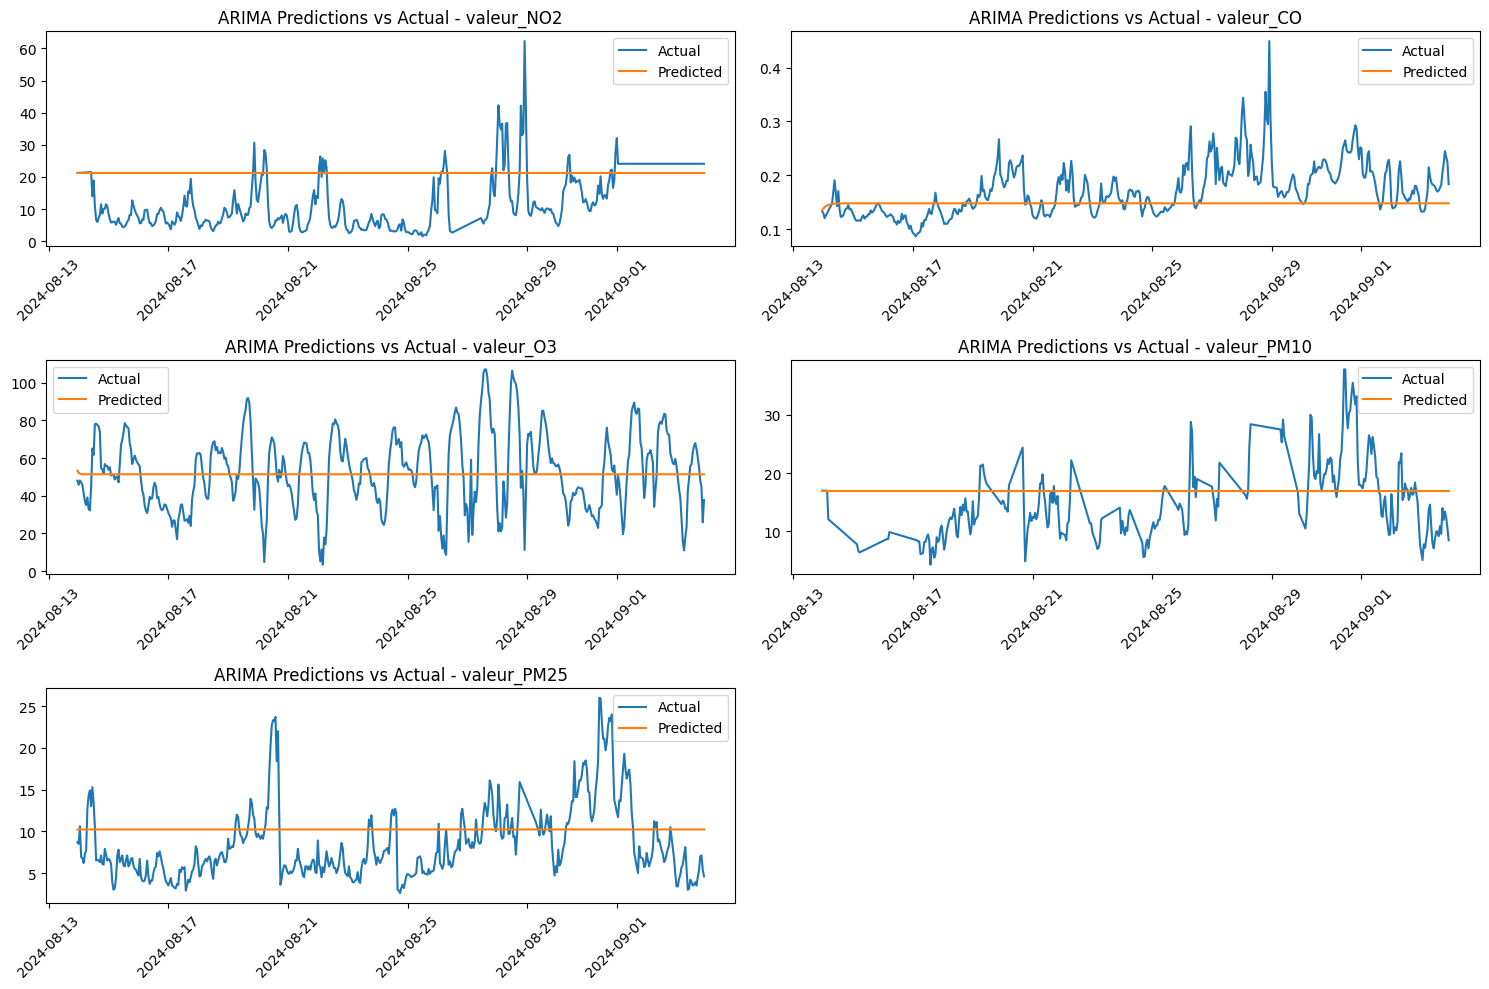

In [6]:
# Prepare data for ARIMA modeling
# We'll model each pollutant separately as a time series
pollutants = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']

# Set date as index for time series analysis
df_ts = df.set_index('date')

# Dictionary to store results
arima_results = {}

for pollutant in pollutants:
    # Split data into train and test (using last 21 days as test) since we have to predict 21 days ahead
    train = df_ts[pollutant][:-504]  # 504 hours = 21 days
    test = df_ts[pollutant][-504:]
    
    # Fit ARIMA model
    # Using order=(1,1,1) as a simple starting point
    model = ARIMA(train, order=(1,1,1))
    model_fit = model.fit()
    
    # Make predictions
    predictions = model_fit.forecast(steps=len(test))
    
    # Calculate metrics
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, predictions)
    
    # Store results
    arima_results[pollutant] = {
        'rmse': rmse,
        'mae': mae,
        'predictions': predictions
    }
    
    print(f"\nResults for {pollutant}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")


plt.figure(figsize=(15, 10))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)
    test = df_ts[pollutant][-504:]
    predictions = arima_results[pollutant]['predictions']
    
    plt.plot(test.index, test.values, label='Actual')
    plt.plot(test.index, predictions, label='Predicted')
    plt.title(f'ARIMA Predictions vs Actual - {pollutant}')
    plt.legend()
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()


In [7]:
for result in arima_results.values():
    print(result['mae'])

# Calculate and print average MAE across all pollutants
average_mae = sum(result['mae'] for result in arima_results.values()) / len(arima_results)
print(f"\nAverage MAE across all pollutants: {average_mae:.2f}")


10.801157311633474
0.03761261588328466
15.968685132506078
5.515881027076883
3.980376072416216

Average MAE across all pollutants: 7.26


# LSTM model

In [105]:
test_dates = pd.read_csv('data/test.csv')

In [106]:
test_dates.head()
test_dates = test_dates.rename(columns={'id': 'date'})
test_dates = test_dates.set_index('date')

In [107]:
test_dates.head()

""
date
2024-09-03 23
2024-09-04 00
2024-09-04 01
2024-09-04 02
2024-09-04 03


In [120]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load datasets
train_pollutants = df
weather_data = weather_df


# Normalize the data
pollutant_scaler = MinMaxScaler(feature_range=(0, 1))
weather_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train_pollutants = pollutant_scaler.fit_transform(train_pollutants)
scaled_weather_data = weather_scaler.fit_transform(weather_data)

# Merge datasets for training
train_data = pd.DataFrame(scaled_train_pollutants, index=train_pollutants.index, columns=train_pollutants.columns)
train_data = train_data.join(pd.DataFrame(scaled_weather_data, index=weather_data.index, columns=weather_data.columns))

# Create sequences
def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
      X.append(data[i:i + seq_length, :-5])  # All features except pollutants
      y.append(data[i + seq_length, -5:])    # Only pollutants as target
  return np.array(X), np.array(y)

seq_length = 24  # Example: using 24 hours of data to predict the next hour
X_train, y_train = create_sequences(train_data.values, seq_length)

# Define the LSTM model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'), 
    Dense(32, activation='relu'),
    Dense(y_train.shape[1])
])

model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1020/1020 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: nan - val_loss: nan
Epoch 2/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: nan - val_loss: nan
Epoch 3/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: nan - val_loss: nan
Epoch 4/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: nan - val_loss: nan
Epoch 5/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: nan - val_loss: nan
Epoch 6/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: nan - val_loss: nan
Epoch 7/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: nan - val_loss: nan
Epoch 8/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: nan - val_loss: nan
Epoch 9/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: nan - val_loss: nan
Epoch 10/100
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: nan - val_loss: nan


In [130]:
# Print information about training data
print("Training data details:")
print("X_train shape:", X_train.shape)
print("Number of features:", X_train.shape[2])

# Get test data and scale it
test_data = weather_data.loc[test_dates.index]
scaled_test_data = weather_scaler.transform(test_data)

# Create sequences with exact same structure as training data
X_test = []
for i in range(len(scaled_test_data) - seq_length):
    sequence = np.zeros((seq_length, X_train.shape[2]))  # Match exact training feature count
    sequence[:, :scaled_test_data.shape[1]] = scaled_test_data[i:i + seq_length]
    X_test.append(sequence)

X_test = np.array(X_test)

print("\nTest data details:")
print("X_test shape:", X_test.shape)
print("Should match:", (len(scaled_test_data) - seq_length, seq_length, X_train.shape[2]))

# Now try predictions
predictions = model.predict(X_test)

Training data details:
X_train shape: (40799, 24, 48)
Number of features: 48

Test data details:
X_test shape: (480, 24, 48)
Should match: (480, 24, 48)
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
